# 0.0 IMPORTS

In [1]:
import random
import warnings
import pandas      as pd
import numpy       as np
import seaborn     as sns

import matplotlib.pyplot as plt
from sklearn.metrics         import confusion_matrix
from scipy                   import stats as ss
from imblearn                import under_sampling as us
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing as pp
from sklearn                 import metrics       as m
from keras                   import models as ml
from keras                   import layers as l
from IPython.core.display    import HTML

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/train_users.csv', low_memory=True) 

df_sessions = pd.read_csv('C:/Users/PC/SejaUmDataScientist/DS_Classificacao/airbnb_project/Data/sessions.csv', low_memory=True)


# 1.0 Passo 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()
df1_sessions = df_sessions.copy()

## 1.1 Data Dimensions

In [5]:
print(f'Número de linhas é igual a: {df1.shape[0]}')
print(f'Número de colunas é igual a: {df1.shape[1]}')

Número de linhas é igual a: 213451
Número de colunas é igual a: 16


In [6]:
#Sessions
print(f'Número de linhas é igual a: {df1_sessions.shape[0]}')
print(f'Número de colunas é igual a: {df1_sessions.shape[1]}')

Número de linhas é igual a: 10567737
Número de colunas é igual a: 6


## 1.2 Data Types

In [7]:
#Data types df1
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [8]:
#Data types df1_sessions
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [9]:
df1.isnull().sum() /len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [10]:
df1_sessions.isnull().sum()

user_id            34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64

## 1.4 Change Data Types

In [11]:
#Verificar a proporção de NA's
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
df1['first_affiliate_tracked'].drop_duplicates()
#aux = df1[df1[ 'age'].isna()]
#aux['country_destination'].value_counts(normalize=True)

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

<AxesSubplot:xlabel='age', ylabel='Density'>

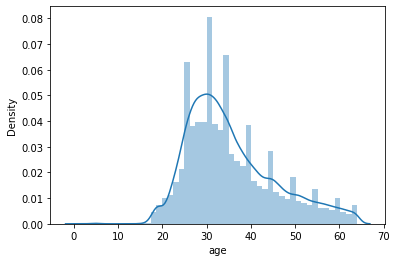

In [13]:
#Analisando a variável idade
sns.distplot(df1 [df1['age'] < 65]['age'])

In [14]:
#Remover NAs
# =====================USERS======================================

#date_first_booking
date_first_booking_max =  pd.to_datetime( df1['date_first_booking']).max().strftime('%Y%m%d')

df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max)

#age: Preencher como valor médio
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age).astype(int)

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


#============================================SESSIONS=========================================
#user_id        3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

#action         0.7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

#action_type    11%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

#action_detail  11%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

#secs_elapsed   1.2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

In [15]:
#df1_sessions 
df1_sessions.isna().sum() / len(df1_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

In [16]:
#date_account_created   
df1['date_account_created']=pd.to_datetime( df1['date_account_created'])
#timestamp_first_active  
df1['timestamp_first_active']=pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking']=pd.to_datetime( df1['date_first_booking'])
#age                      
df1['age']= df1['age'].astype('int64')

## 1.5 Check Balanced Data

In [17]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

## 1.6 Descriptive Analyses

In [18]:
#==================Users===================================
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes( include= ['datetime64[ns]'])


#====================Sessions==========================================
num_attributes_sessions  = df1_sessions.select_dtypes( include=['int64', 'float64'])
cat_attributes_sessions  = df1_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df1_sessions.select_dtypes( include= ['datetime64[ns]'])

### 1.6.1 Numerical -Users

In [19]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,1.0,2014.0,2013.0,49.183142,49.0,118.421689,16.333820,267.655434
1,signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543915,2.287158,3.567794


Nessa primeira análise, é possível perceber que há valores incorretos na coluna age, dado que o  valor min é igual a 1 e máx igual a 2014.
Na sessão de feature engeneering isso será tratado.

### 1.6.1 Numerical -Sessions

In [20]:
#central tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes_sessions.apply(np.median)).T

#Dispersions -  std, min, max. range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame( num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame( num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.skew() )).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x : x.kurtosis() )).T

#Concatenar
ct = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2 Numerical - Users

In [21]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 1.6.3 Categorical -Sessions

In [22]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [23]:
#lista de atributos para cramer v
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}

for i in range( len(cat_attributes_list) ):
    corr_list = []
    
    for j in range (len(cat_attributes_list ) ):
        ref  = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #Correlação
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat] )
        
        #append a list
        corr_list.append( corr )
    # append correlation para cada ref atrtibuts
    corr_dict[ref] = corr_list

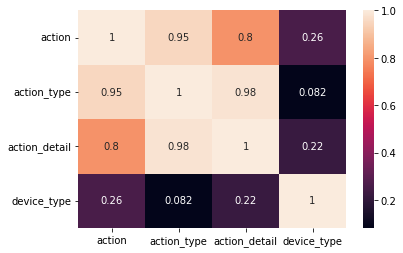

In [24]:
d = pd.DataFrame( corr_dict)
d = d.set_index(d.columns)
sns.heatmap( d, annot=True);

Neste caso podemos verificar que as colunas action e action type  são muito correlacionadas, ou seja, as duas tem basicamente a mesma informação.logo podemos excluir uma delas.

# 2.0 Feature Engeneering


In [25]:
df2 =df1.copy()
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create new Features

In [26]:
# days from first activate up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime("%Y-%m-%d") )
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] -df2['first_active']).apply( lambda x: x.days)

#days from first activate up to account create
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] -df2['first_active']).apply( lambda x: x.days)

#days from account create up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] -df2['date_account_created']).apply( lambda x: x.days)
    

#===================================First activate======================================
#Year first active
df2['year_first_active'] = df2['first_active'].dt.year

#Month first active
df2['month_first_active'] = df2['first_active'].dt.month


#Day first active
df2['day_first_active'] = df2['first_active'].dt.day


#Day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek


#Week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===================================Booking======================================
#Year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#Month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#Day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#Day of Week of first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#Week of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear


#===================================First account created======================================
#Year first active
df2['year_account_created'] = df2['date_account_created'].dt.year

#Month first active
df2['month_account_created'] = df2['date_account_created'].dt.month


#Day first active
df2['day_account_created'] = df2['date_account_created'].dt.day


#Day of week first active
df2['day_of _week_first_account_created'] = df2['date_account_created'].dt.dayofweek


#Week of year first active
df2['week_of _year_first_account_created'] = df2['date_account_created'].dt.weekofyear

In [27]:
df2.shape

(207386, 35)

# 3.0 Data Filtering


In [28]:
df3 = df2.copy()

## 3.1 Filtering Rows

In [29]:
#Age:entre 15 e 120 pois há poucas pessoas como mais de 120 anos
df3 =  df3[( df2['age']> 15) & (df3['age'] < 120 )]

# secs_elapsed - Não há possibilidade de ter 0 elapsed
#df1_sessions = df1_sessions[ df1_sessions['secs_elapsed']> 0]

## 3.2 Columns Selection

In [30]:
cols = ['date_account_created', 'date_first_booking','first_active','timestamp_first_active'] #Original datetime
df3 = df3.drop(cols, axis=1)

# 4.0 Balanced Dataset

In [31]:
df4= df3.copy()

## 4.1 Random Undersampling

In [32]:
#define sample
undersampling = us.RandomUnderSampler( sampling_strategy= 'auto', random_state=32)

#apply sampler
X_under, y_under = undersampling.fit_resample(df4, df4['country_destination'])

In [33]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

In [34]:
y_under.value_counts()

AU       213
CA       213
DE       213
ES       213
FR       213
GB       213
IT       213
NDF      213
NL       213
PT       213
US       213
other    213
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

## 4.1 Smote + Tomeklink

In [31]:
# Dummy Variable
df4_dummy = pd.get_dummies( df4.drop( ['id','country_destination'], axis=1 ) )

#Join ID and country_destiantion
df4 =pd.concat( [  df4[['id', 'country_destination']], df4_dummy],axis=1)
df4


,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,first_active,days_from_first_active_until_booking,days_from_first_active_until_account_created,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,gxn3p5htnn,NDF,2010-06-28,2009-03-19 04:32:55,2015-06-29,49,0,2009-03-19,2293,466,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,NDF,2011-05-25,2009-05-23 17:48:09,2015-06-29,38,0,2009-05-23,2228,732,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,2009-06-09,419,476,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,2009-10-31,1043,765,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,2009-12-08,72,280,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,NDF,2014-06-30,2014-06-30 23:56:36,2015-06-29,32,0,2014-06-30,364,0,...,0,0,0,0,0,0,0,0,0,0
213447,mhewnxesx9,NDF,2014-06-30,2014-06-30 23:57:19,2015-06-29,49,0,2014-06-30,364,0,...,0,0,0,0,0,0,0,0,0,0
213448,6o3arsjbb4,NDF,2014-06-30,2014-06-30 23:57:54,2015-06-29,32,0,2014-06-30,364,0,...,0,0,0,0,0,0,0,0,0,0
213449,jh95kwisub,NDF,2014-06-30,2014-06-30 23:58:22,2015-06-29,49,25,2014-06-30,364,0,...,0,0,0,0,0,0,0,0,0,0


# 5.0 PASSO 05 - Feature Selection

In [32]:
#Deletar as colunas desnecessarias pro modelo
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active']
df5= df4.drop(cols_drop, axis=1)

In [33]:
X = df5.drop(['id', 'country_destination'], axis=1)
y = df5['country_destination'].copy()

In [34]:
#Split dataset
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 ) 

# 6.0 PASSO 06 - Machine Learning Model

In [35]:
x_train = X_train
x_test = X_test

In [36]:
x_train.head()

,age,signup_flow,days_from_first_active_until_booking,days_from_first_active_until_account_created,days_from_account_created_until_first_booking,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,...,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
38694,49,0,8,0,8,2012,8,29,2,35,...,0,0,0,0,0,0,0,0,0,0
115575,49,0,628,0,628,2013,10,9,2,41,...,0,0,0,0,0,0,0,0,0,0
85496,40,0,28,0,28,2013,6,21,4,25,...,0,0,0,0,0,0,0,0,0,0
180102,49,0,431,0,431,2014,4,24,3,17,...,0,0,0,0,0,0,0,0,0,0
166815,49,25,462,0,462,2014,3,24,0,13,...,0,0,0,0,0,0,0,0,0,0


## 6.1 Baseline Model 

In [37]:
#random.choices(populacao =, weght= , k=)
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().to_list()
k_num = y_test.shape[0]
country_destination_weghts = df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

# Modelo aleatório
yhat_random = random.choices(population= country_destination_list, 
                             weights = country_destination_weghts,
                             k = k_num)


### 6.1.1 Baseline Model Performance

Accuracy: 0.4275
Balanced Accuracy: 0.0830
Balanced Accuracy: 0.0029


              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.01      0.01      0.01       385
          FR       0.02      0.02      0.02       971
          GB       0.01      0.01      0.01       457
          IT       0.01      0.01      0.01       553
         NDF       0.58      0.58      0.58     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.30      0.29      0.30     12249
       other       0.05      0.05      0.05      1980

    accuracy                           0.43     41319
   macro avg       0.08      0.08      0.08     41319
weighted avg       0.43      0.43      0.43     41319



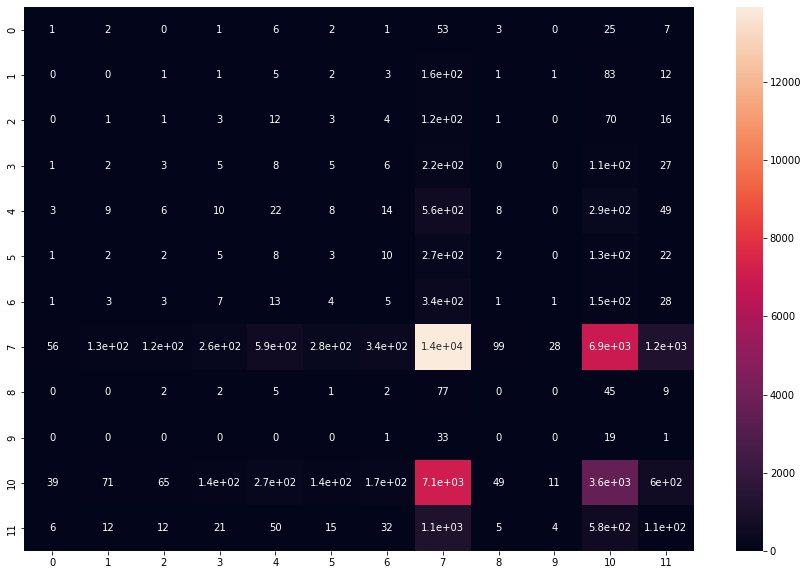

In [48]:
#Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random:.4f}')

#Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random:.4f}')

#Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Balanced Accuracy: {kappa_random:.4f}')
print('\n')

#Classification Report
print(m.classification_report(y_test, yhat_random))

#Confusion Matrix
cm = confusion_matrix( y_test, yhat_random)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);


## 5.2 Neural Network - MLP

In [39]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1 ) ).toarray()

In [40]:
#df1['country_destination'].value_counts(normalize=True).sort_index().to_list()

In [41]:
# Model definition
model = ml.Sequential()
model.add(l.Dense( 256, input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense( 12, activation='softmax') )

#Model compile
model.compile( loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'] )

#training model
model.fit( x_train , y_train_nn, epochs=100 )

Epoch 1/100
5165/5165 [==============================] - 14s 2ms/step - loss: 3.9825 - accuracy: 0.7941
Epoch 2/100
5165/5165 [==============================] - 10s 2ms/step - loss: 1.2996 - accuracy: 0.8210
Epoch 3/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.7574 - accuracy: 0.8430
Epoch 4/100
5165/5165 [==============================] - 9s 2ms/step - loss: 0.5564 - accuracy: 0.8648
Epoch 5/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.5058 - accuracy: 0.8722
Epoch 6/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.4989 - accuracy: 0.8731
Epoch 7/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.4979 - accuracy: 0.8732
Epoch 8/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.4977 - accuracy: 0.8732
Epoch 9/100
5165/5165 [==============================] - 10s 2ms/step - loss: 0.4969 - accuracy: 0.8733
Epoch 10/100
5165/5165 [==============================] - 10s 2ms

In [42]:
#Predict
pred_nn = model.predict( x_test )

#invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

#Prediction Prepare
y_test_nn = y_test.to_numpy()
yhat_nn =  yhat_nn.reshape(1, -1 )[0]

1292/1292 [==============================] - 2s 1ms/step


Accuracy: 0.8755052155182845
Balanced Accuracy: 0.16665986339020875
Kappa score: 0.7694020449633958


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       265
          DE       0.00      0.00      0.00       234
          ES       0.00      0.00      0.00       385
          FR       0.00      0.00      0.00       971
          GB       0.00      0.00      0.00       457
          IT       0.00      0.00      0.00       553
         NDF       1.00      1.00      1.00     23927
          NL       0.00      0.00      0.00       143
          PT       0.00      0.00      0.00        54
          US       0.70      1.00      0.83     12249
       other       0.00      0.00      0.00      1980

    accuracy                           0.88     41319
   macro avg       0.14      0.17      0.15     41319
weighted avg       0.79      0.88      0.82     41319



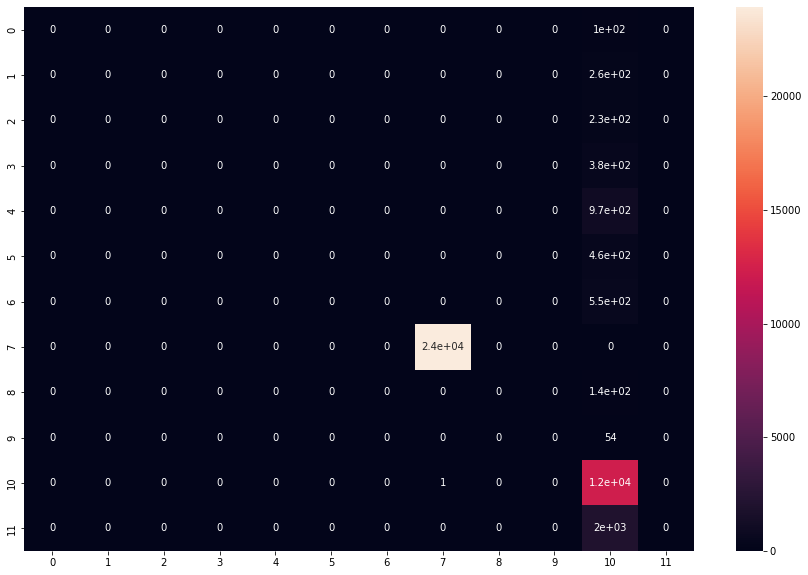

In [43]:
#Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

#Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

#Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa score: {kappa_nn}')
print('\n')

#Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

#Confusion Matrix
cm = confusion_matrix( y_test_nn, yhat_nn)
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True);



## 5.2.3 NN Performance - Cross Validation

In [45]:
#Generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Fold number {i}/{num_folds}\n')
    #Get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot_encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape( -1, 1)).toarray()
    
    #Model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))
    
    #Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    
    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform( pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1)[0]
    
    #metrics
    
    #Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn)
   
    #Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn)
    
    i += 1

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

In [ ]:
print(f'Avg Balanced Accuracy: {np.mean(balanced_acc_list)} +/- {np.std(balanced_acc_list)}\n')
      
print(f'Avg Kappa: {np.mean(kappa_acc_list)} +/- {np.std(kappa_acc_list)}')

In [ ]:
x_train_fold.shape

In [ ]:
y_train_nn.shape